# **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note** If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os
import pickle 
from scipy.interpolate import UnivariateSpline


pi = 3.14159
fac_imgY = 1.625
%matplotlib inline

(540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


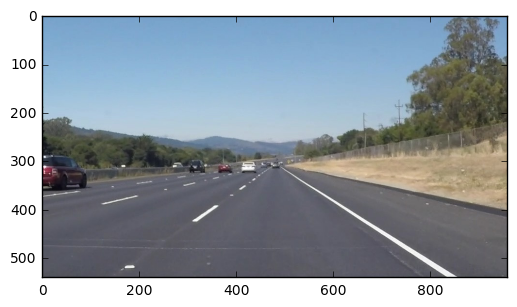

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
#image = mpimg.imread('test_images/lightbackground.jpg')

print(np.shape(image))

#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  #call as plt.imshow(gray, cmap='gray') to show a grayscaled image

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [3]:
import math

def auto_canny(image, sigma=0.33):
    # compute the median of the single channel pixel intensities
    v = np.median(image)
    # apply automatic Canny edge detection using the computed median
    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma) * v))
    edged = cv2.Canny(image, lower, upper)
 
    # return the edged image
    return edged

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)
            

            
def get_sidelines(img, lines, color=[255, 0, 0], thickness=2):            
    ang_all = []
    line_all = []
    for line in lines:
        for x1,y1,x2,y2 in line:
            ang_all.append(math.atan2((y2-y1),(x2-x1)))
            line_all.append(line[0])
    ang_all = np.array(ang_all)
    ang_center = np.mean(ang_all)
    
    i_ang_left = [i for i in range(len(ang_all)) \
              if ((ang_all[i]<np.mean(ang_all)) & (abs(abs(ang_all[i])-.6)<.2))]
    ang_left = ang_all[i_ang_left]
    i_ang_right = [i for i in range(len(ang_all))\
              if ((ang_all[i]>=np.mean(ang_all)) & (abs(abs(ang_all[i])-.6)<.2))]
    ang_right = ang_all[i_ang_right]
    ang_center = np.mean(ang_all)

    line_all = np.array(line_all)
    i_ang_left = np.array(i_ang_left,dtype=np.int32)
    i_ang_right = np.array(i_ang_right,dtype=np.int32)
    line_right = line_all[i_ang_right]
    line_left = line_all[i_ang_left]
    
    return line_left,line_right        
            

    
    
def draw_sidelines2(img,img_org, line_left,line_right, color=[255, 0, 0], thickness=2):            
    if ((len(line_left)!=0)&(len(line_right)!=0)):
        [x_bl,y_bl,x_tl,y_tl] = fitlines_sides(line_left)
        [x_br,y_br,x_tr,y_tr] = fitlines_sides(line_right)

        x_dim = np.shape(img_org)[1]
        y_dim = np.shape(img_org)[0]
        #print(x_dim,x_br,x_bl)
        if os.path.isfile('prev_markings.pkl'):    # True  
            prev_markings = pickle.load( open( "prev_markings.pkl", "rb" ) )
            left_prev = prev_markings[0]
            right_prev = prev_markings[1]
            # If out of region, use previous value
            
            if abs(x_dim/2-x_br)>x_dim/2:
                x_br = right_prev[0]
                y_br = right_prev[1]
                
            if abs(x_dim/2-y_tr)>200:
                x_tr = right_prev[2]
                y_tr = right_prev[3]

            if abs(x_dim/2-x_bl)>x_dim/2:
                x_bl = left_prev[0]
                y_bl = left_prev[1]
            
            if abs(x_dim/2-x_tl)>400:
                x_tl = left_prev[2]
                y_tl = left_prev[3]      
            
            x_br_p = right_prev[0]
            y_br_p = right_prev[1]
            x_tr_p = right_prev[2]
            y_tr_p = right_prev[3]
               
            x_bl_p = left_prev[0]
            y_bl_p = left_prev[1]
            x_tl_p = left_prev[2]
            y_tl_p = left_prev[3]
                        
            if abs(x_br-x_br_p)>100:
                x_br = x_br_p
                y_br = y_br_p
            if abs(x_tr-x_tr_p)>100:
                x_tr = x_tr_p
                y_tr = y_tr_p
            
            if abs(x_bl-x_bl_p)>100:
                x_bl = x_bl_p
                y_bl = y_bl_p
            if abs(x_tl-x_tl_p)>100:
                x_tl = x_tl_p
                y_tl = y_tl_p                
            
            fac_filt = 0.9
            x_br = math.floor((1-fac_filt)*x_br + fac_filt*x_br_p)
            y_br = math.floor((1-fac_filt)*y_br + fac_filt*y_br_p)
            x_tr = math.floor((1-fac_filt)*x_tr + fac_filt*x_tr_p)
            y_tr = math.floor((1-fac_filt)*y_tr + fac_filt*y_tr_p)
            
            x_bl = math.floor((1-fac_filt)*x_bl + fac_filt*x_bl_p)
            y_bl = math.floor((1-fac_filt)*y_bl + fac_filt*y_bl_p)
            x_tl = math.floor((1-fac_filt)*x_tl + fac_filt*x_tl_p)
            y_tl = math.floor((1-fac_filt)*y_tl + fac_filt*y_tl_p)
            
            
            prev_markings = [[x_bl,y_bl,x_tl,y_tl],[x_br,y_br,x_tr,y_tr]]
            pickle.dump( prev_markings, open( "prev_markings.pkl", "wb" ) )
        else:
            prev_markings = [[146, 540, 453, 325], [849, 540, 510, 325]]
            #[[144,540,460,270],[816,240,500,270]]
            print('Previous marking file doesnt exist, making one')
            pickle.dump( prev_markings, open( "prev_markings.pkl", "wb" ) )
            
        
        x_bc = math.floor((x_bl+x_br)/2)
        y_bc = math.floor((y_bl+y_br)/2)
    
        x_tc = math.floor((x_tl+x_tr)/2)
        y_tc = math.floor((y_tl+y_tr)/2)
    

        x_bcam = math.floor(x_dim/2)
        x_tcam = math.floor(x_dim/2)
        y_bcam = math.floor(y_tc)
        y_tcam = math.floor(y_dim)

    
    
        # testing line colors. 
        col_yellow = np.array([240, 200, 100],dtype=np.float)
    
        line_data_lr = [[x_bl,y_bl,x_tl,y_tl],
                   [x_br,y_br,x_tr,y_tr]]
        img_sz = np.shape(img)
        for line_data in line_data_lr:
            bool_col = test_line_color(line_data,col_yellow,img_org,6)
            #img_HLS = cv2.cvtColor(img_org, cv2.COLOR_RGB2HLS)
            #bool_col = test_line_color_hue(line_data,col_yellow,img_HLS,5)
            if bool_col:
                cv2.line(img, (line_data[0],line_data[1]), 
                         (line_data[2],line_data[3]), [255,255,0], 25)
                
        
    
    
        vertices = np.array([[(x_tl,y_tl),(x_bl,y_bl),
                          (x_br,y_br),(x_tr,y_tr)]],
                        dtype = np.int32)
    
        cv2.line(img, (x_bl,y_bl), (x_tl,y_tl), [255,0,0], 12)
        cv2.line(img, (x_br,y_br), (x_tr,y_tr),  [255,0,0], 12)
        cv2.line(img, (x_bcam,y_bcam), (x_tcam,y_tcam),
             [120,120,0], 4)
        if abs(x_bc-x_bcam)>50:
            cv2.line(img, (x_bc, y_bc), (x_tc, y_tc), [255,0,0], 15)
            #cv2.fillPoly(img, vertices,[255,0,0] )
        else:
            cv2.line(img, (x_bc, y_bc), (x_tc, y_tc), [0,255,0], 2)
            #cv2.fillPoly(img, vertices,[0,100,0] )

    
    
def draw_sidelines(img,img_org, lines, color=[255, 0, 0], thickness=2):            
    ang_all = []
    line_all = []
    for line in lines:
        for x1,y1,x2,y2 in line:
            ang_all.append(math.atan2((y2-y1),(x2-x1)))
            line_all.append(line[0])
    ang_all = np.array(ang_all)
    ang_center = np.mean(ang_all)
    
    i_ang_left = [i for i in range(len(ang_all)) \
              if ((ang_all[i]<np.mean(ang_all)) & (abs(abs(ang_all[i])-.6)<.2))]
    ang_left = ang_all[i_ang_left]
    i_ang_right = [i for i in range(len(ang_all))\
              if ((ang_all[i]>=np.mean(ang_all)) & (abs(abs(ang_all[i])-.6)<.2))]
    ang_right = ang_all[i_ang_right]
    ang_center = np.mean(ang_all)

    line_all = np.array(line_all)
    i_ang_left = np.array(i_ang_left,dtype=np.int32)
    i_ang_right = np.array(i_ang_right,dtype=np.int32)
    line_right = line_all[i_ang_right]
    line_left = line_all[i_ang_left]
    
    
    if ((len(line_left)!=0)&(len(line_right)!=0)):
        [x_bl,y_bl,x_tl,y_tl] = fitlines_sides(line_left)
        [x_br,y_br,x_tr,y_tr] = fitlines_sides(line_right)
    
        x_bc = math.floor((x_bl+x_br)/2)
        y_bc = math.floor((y_bl+y_br)/2)
    
        x_tc = math.floor((x_tl+x_tr)/2)
        y_tc = math.floor((y_tl+y_tr)/2)
    
        x_dim = np.shape(img)[1]
        y_dim = np.shape(img)[0]
    
        x_bcam = math.floor(x_dim/2)
        x_tcam = math.floor(x_dim/2)
        y_bcam = math.floor(y_tc)
        y_tcam = math.floor(y_dim)

    
    
        # testing line colors. 
        col_yellow = np.array([240, 200, 100],dtype=np.float)
    
        line_data_lr = [[x_bl,y_bl,x_tl,y_tl],
                   [x_br,y_br,x_tr,y_tr]]
        img_sz = np.shape(img)
        for line_data in line_data_lr:
            bool_col = test_line_color(line_data,col_yellow,img_org,6)
            if bool_col:
                cv2.line(img, (line_data[0],line_data[1]), 
                         (line_data[2],line_data[3]), [255,255,0], 25)
                
        
    
    
        vertices = np.array([[(x_tl,y_tl),(x_bl,y_bl),
                          (x_br,y_br),(x_tr,y_tr)]],
                        dtype = np.int32)
    
        cv2.line(img, (x_bl,y_bl), (x_tl,y_tl), [255,0,0], 12)
        cv2.line(img, (x_br,y_br), (x_tr,y_tr),  [255,0,0], 12)
        cv2.line(img, (x_bcam,y_bcam), (x_tcam,y_tcam),
             [120,120,0], 4)
        if abs(x_bc-x_bcam)>50:
            cv2.line(img, (x_bc, y_bc), (x_tc, y_tc), [255,0,0], 15)
            #cv2.fillPoly(img, vertices,[255,0,0] )
        else:
            cv2.line(img, (x_bc, y_bc), (x_tc, y_tc), [0,255,0], 2)
            #cv2.fillPoly(img, vertices,[0,100,0] )
        
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), 
                            minLineLength=min_line_len, 
                            maxLineGap=max_line_gap)
    return lines

# Python 3 has support for cool math symbols.


def fitlines_sides(line_side):
    x1_s = line_side[:,0]
    y1_s = line_side[:,1]
    x2_s = line_side[:,2]
    y2_s = line_side[:,3]

    x_s = np.append(x1_s,x2_s)
    y_s = np.append(y1_s,y2_s)

    xy_s = np.array([x_s,y_s]).T
    [vx,vy,px,py] = cv2.fitLine(xy_s,cv2.DIST_L2,0,0.01,0.01)
    #print(line_side)
    # bottom intercept
    y_dim = np.shape(image)[0]
    x_dim = np.shape(image)[1]

    y_bot = math.floor(y_dim)
    
    bool_ret = False
    
    gam = (y_bot-py)/vy
    x_bot = vx*gam+px
    x_bot = math.floor(x_bot[0])
    
    y_top = y_dim/fac_imgY
    gam = (y_top-py)/vy
    x_top = vx*gam+px
    x_top = math.floor(x_top[0])
    y_top = math.floor(y_top)
    bool_ret = True
    return x_bot,y_bot,x_top,y_top



def test_line_color(line_data,col_test,img,n_pts=10):
    img_sz = np.shape(img)
    cos_similarity = []
    x_dim = img_sz[1]
    y_dim = img_sz[0]
    bool_col = True
    num_col = 0
    for i in np.arange(1,n_pts):
        xb = np.float(line_data[0])
        yb = np.float(line_data[1])
        xt = np.float(line_data[2])
        yt = np.float(line_data[3])
    
        fac = (i)/n_pts; 
    
        xp = math.floor(xb + fac*(xt-xb))
        yp = math.floor(yb + fac*(yt-yb))
        
        #print('pts',xp,yp,xb,yb,xt,yt)
        
        if ((xp>0)&(xp<x_dim)&(yp>0)&(yp<y_dim)):
            
            for i_col_test in range(61):
                yp_test = yp-1
                xp_test = xp-i_col_test+30
                if (yp-1)<0:
                    yp_test = 1

                if (yp-1)>=x_dim:
                    yp_test=x_dim-1
                if yp<0:
                    yp = 1

                if (xp-i_col_test+30)>=x_dim:
                    xp_test=y_dim-1
                            
                if (xp-i_col_test+30)<1:
                    xp_test=1
                            
                col_vec = np.array(img[yp_test,xp_test],dtype=np.float)
                col_test = np.array(col_test,dtype=np.float32)
                sim_test = np.mean(abs(col_vec-col_test))
                sim_test = np.mean(abs(col_vec-col_test))
                if sim_test<20:
                    num_col += 1
                    break
    
    
    if num_col>=2:
        bool_col = True
    else:
        bool_col = False
        

    #print(bool_col)
    '''
    if bool_col:
        avg_color = np.median(cos_similarity,axis = 0)
        col_test = np.array(col_test,dtype=np.float32)
        sim_test = np.mean(abs(avg_color-col_test))
        if sim_test<15:
            bool_col = True
        else:
            bool_col = False
    '''
    return bool_col

def weighted_img(img, initial_img,α=0.8,β=1.0,λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)


def get_frames_from_video(vid_name):
    vidcap = cv2.VideoCapture(vid_name)
    success,image = vidcap.read()
    count = 0
    success = True
    while success:
        success,image = vidcap.read()
        cv2.imwrite("frame%d.jpg" % count, image)     # save frame as JPEG file
        if cv2.waitKey(10) == 27:                     # exit if Escape is hit
            break
        count += 1
    print(count,' frames saved in folder.')
    
    
    
def get_region_lines(img,vertc):
    kernel_size = 5
    img_gauss = gaussian_blur(img,kernel_size)
    img_gauss = np.uint8(img_gauss)


    im = canny(img_gauss,100,110)
    im = region_of_interest(im, vertc)    
    lines = hough_lines(im, 
                              2, # rho 
                              np.pi/180, #theta 
                              10, #threshold
                              32, #min_line_len
                              64 #max_line_gap
                             )
    if (lines == None):
        line_left=[]
        line_right=[]
    else:
        line_left,line_right = get_sidelines(im, lines)
    return line_left,line_right

## Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [4]:
import os
os.listdir("test_images/")

['horzLineTest.jpg',
 'solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

run your solution on all test_images and make copies into the test_images directory).

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

In [5]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [6]:
def process_image(img_orginal):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)
    
    
    img_orginal = cv2.resize(img_orginal,(960,540), interpolation = cv2.INTER_CUBIC)

    x_dim = np.shape(img_orginal)[1]
    y_dim = np.shape(img_orginal)[0]
    vertices = np.array([[(10,y_dim-200),(x_dim-10,y_dim-200),
                  (x_dim/2+20,y_dim/fac_imgY),(x_dim/2-20,y_dim/fac_imgY)]],
               dtype = np.int32)

    img_cvt = cv2.cvtColor(img_orginal, cv2.COLOR_RGB2HLS)

    line_left1,line_right1 = get_region_lines(img_cvt[:,:,1],vertices)
    
    line_left2,line_right2 = get_region_lines(img_cvt[:,:,2],vertices)
    
    if len(line_left1)>len(line_left2):
        line_left = line_left1
    else:
        line_left = line_left2
    
    if len(line_right1)>len(line_right2):
        line_right = line_right1
    else:
        line_right = line_right1
    

    line_img = np.zeros(img_orginal.shape, dtype=np.uint8)
    
    
    
    draw_sidelines2(line_img,img_orginal, line_left,line_right)


    img_wt = weighted_img(line_img, img_orginal, 0.9, 0.5, 0.5)

    return img_wt

Let's try the one with the solid white lane on the right first ...

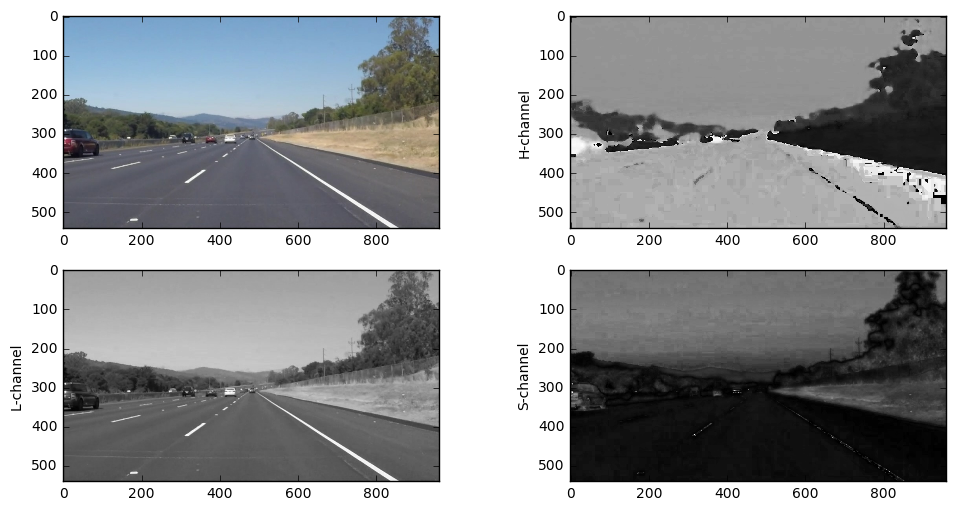

In [8]:
#os.remove("prev_markings.pkl")
image = mpimg.imread('test_images/solidWhiteRight.jpg')
#image = mpimg.imread('test_images/lightbackground.jpg')
img_cvt = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)

plt.figure(figsize=(12,6))
plt.subplot(2,2,1)
plt.imshow(image)
plt.subplot(2,2,2)
plt.imshow(img_cvt[:,:,0],cmap='gray')
plt.ylabel('H-channel')
plt.subplot(2,2,3)
plt.imshow(img_cvt[:,:,1],cmap='gray')
plt.ylabel('L-channel')
plt.subplot(2,2,4)
plt.imshow(img_cvt[:,:,2],cmap='gray')
plt.ylabel('S-channel')


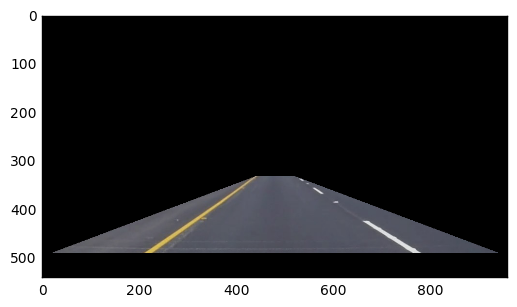

In [9]:
#os.remove("prev_markings.pkl")
image = mpimg.imread('test_images/solidYellowLeft.jpg')
#image = mpimg.imread('challenge_images/frame14.jpg')
img_cvt = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)

x_dim = np.shape(image)[1]
y_dim = np.shape(image)[0]
vertices = np.array([[(20,y_dim-50),(x_dim-20,y_dim-50),
                  (x_dim/2+40,y_dim/fac_imgY),(x_dim/2-40,y_dim/fac_imgY)]],
               dtype = np.int32)
img_cv_h = img_cvt[168:248,457:537,0]

img_prc = process_image(image)

im = region_of_interest(img_prc, vertices)

plt.imshow(im);

In [ ]:
os.remove("prev_markings.pkl")

white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4");
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False);

Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [ ]:
os.remove("prev_markings.pkl")
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflections

Congratulations on finding the lane lines!  As the final step in this project, we would like you to share your thoughts on your lane finding pipeline... specifically, how could you imagine making your algorithm better / more robust?  Where will your current algorithm be likely to fail?

Please add your thoughts below,  and if you're up for making your pipeline more robust, be sure to scroll down and check out the optional challenge video below!


## Response 

### 1. The Algorithm
In this project, I implemented detection and tracking algorithm to first identify the side lines while diriving in a traffic lane. I then applied a yellow-color detection algorithm to determine if the line was a yellow line. 

#### Lane detection

The main lane detection algorithm works as follows, 

1. Covert RGB image to HLS image: I first converted RGB to HLS color map, because HLS color maps are less sensitive to variations in shadow or brightness.
2. Choose between L or S channel: I took the (L)uminiscense channel and (S)aturation channels, applied 5-kernel Gaussian filter and applied canny edge detection. After applying canny edge detection, I counted the number of lines that were within +/-.2 of 0.6 radians (these angles represent the two side lines). I then chose the channel that gave most lines within the possible angle range, and used that channel for further processing. 
3. I applied least-square fitting on lines with negative and positive slopes to compute lanes based on the current image. 

#### Lane tracking

After computing lanes based on the current image, I applied a first order filter to smooth out the lanes, and discard any large deviations due to errorneous detection. 

1. Any disturbance larger than 60 pixels in the x-direction was rejected
2. Any measurement that had intercepts with the bottom of the image out side the image was rejected
3. The main tracking algorithm was \\( newLane = 0.9oldLane + 0.1newLane \\). 

#### Yellow lane detection

After computing the two side lanes, I next computed if a given lane was yellow or not. To do so, I took 5 equidistant points between the start and the end of the line, and computed colors of the pixels along a horizontal line of width 60 pixels centered at theee points along the line. If more than 2 points were found to have yellow color, the lane was determined to be yellow. I checked yellow color based on RGB map, and I took yellow color as \\( [240~200~100]\\)

#### Lane departure warning

I also included a simple lane-departure warning system. In all the videos, green is the center of the lane, and light yellow is the middle of the image. So if the deviation between the center of the lane and the center of the image is larger than 50 pixels, the green line turns red, to inform the driver that the car is wavering. 

### 2. Algorithm Performance

The algorithm presented above works very well on detecting and tracking lanes for all the test cases presented in this project. The yellow color detection fails in few frames of the challenge video. 

### 3. Further improvements

The technique presented above works reasonably well for the videos presented in the project. However, there are several aspects that have been ignored, for example,

1. The algorithm doesnt account for writing on the lane. Although filtering should be able to remove artifacts of writings, but based on this data alone, it is not possible to determine its effectiveness in doing so.
2. The algorithm is likely to fail in scenarios when there is a lot of traffic, and the lanes are not clearly visible. 
3. The algorithm does not account for velocity in its current implementation, therefore, if the car encounters a scenario where the car is stationary, and no lanes are painted on the road. The current algorithm will tend to keep updating measurements. The algorithm can further improved by adding velocity feedback, so updates that come below a certain velocity threshold are weighed less. 
4. The current algroithm fails to track yellow color in dark shadow regions, in a few frames in the challenge image. The algroithm can be further improved by implementing a color-based tracking along with Luminosity and saturation. However, this may increase the computation time.
5. The algorithm performs slightly poor and is less responsive due to introduction of first-order filter. This aspect can be improved by using a gain matrix thats dependent on the incoming error signal. 


## Submission

If you're satisfied with your video outputs it's time to submit!


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [ ]:
os.remove("prev_markings.pkl")
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))

In [ ]:
os.remove("prev_markings.pkl")

fVu_output = 'fineVu_youtube.mp4'
clip1 = VideoFileClip("fineVu.mp4");
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(fVu_output, audio=False);

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(fVu_output))